In [5]:
import mindspore as ms
from mindspore import nn, Tensor
import numpy as np
import xarray as xr
from mindspore import dataset as ds
from mindspore import dtype as mstype
import matplotlib.pyplot as plt

In [6]:
# 搭建用于预测ENSO的CNN网络
class ConvNetwork(nn.Cell):
    """
    M_Num, N_Num: convolutional filters和FCN层的神经元数量
    """
    def __init__(self, M_Num, N_Num):
        super(ConvNetwork, self).__init__()
        self.M = M_Num
        self.N = N_Num
        self.conv = nn.SequentialCell(
            nn.Conv2d(6, M_Num, kernel_size=(4, 8), pad_mode='same', has_bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(M_Num, M_Num, kernel_size=(4, 2), pad_mode='same', has_bias=True),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(M_Num, M_Num, kernel_size=(4, 2), stride=(1, 1), pad_mode='same', has_bias=True),
            nn.Tanh()
        )
        self.FCN = nn.SequentialCell(
            nn.Dense(6 * 18 * M_Num, N_Num),
            nn.Dense(N_Num, 23)
        )

    def construct(self, InData, *args, **kwargs):
        x = self.conv(InData)
        x = x.reshape((-1, 6 * 18 * self.M))  # MindSpore使用reshape代替view
        x = self.FCN(x)
        return x

In [11]:
# 指定数据集所在路径
# 多个CMIP数据合在一起用于模型的预训练
CMIPTosLoc_1 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\GFDL-ESM4_TosA_rename.nc"
CMIPZosLoc_1 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\GFDL-ESM4_ZosA_rename.nc"
CMIPNinoLoc_1 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\GFDL-ESM4_Nino34I_rename.nc"

CMIPTosLoc_2 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\NorESM2-MM_TosA_rename.nc"
CMIPZosLoc_2 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\NorESM2-MM_ZosA_rename.nc"
CMIPNinoLoc_2 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\NorESM2-MM_Nino34.nc"

CMIPTosLoc_3 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\IPSL-CM6A-LR_TosA_rename.nc"
CMIPZosLoc_3 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\IPSL-CM6A-LR_ZosA_rename.nc"
CMIPNinoLoc_3 = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\IPSL-CM6A-LR_Nino34.nc"

# OBSTrain数据用于微调
OBSTrainSSTALoc = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\ersstv5ssta.nc"
OBSTrainSSHALoc = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\SODAssha.nc"
OBSTrainNinoLoc = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\TrainData\ersstv5Nino34.nc"

# OBSVal数据用于验证
OBSValSSTALoc = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\ValidationData\ersstv5ssta.nc"
OBSValSSHALoc = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\ValidationData\GODASssha.nc"
OBSValNinoLoc = r"D:\Desktop\huawei-ai\ENSO-forecast-mindspore\ValidationData\ersstv5Nino34.nc"

In [15]:
# 创建数据集类
class ENSODataset:
    def __init__(self, type_, T_begin, T_end):
        self.Type = type_
        if type_ == "CMIP":
            datasets = [
                self._load_single_cmip(CMIPTosLoc_1, CMIPZosLoc_1, CMIPNinoLoc_1, T_begin, T_end),
                self._load_single_cmip(CMIPTosLoc_2, CMIPZosLoc_2, CMIPNinoLoc_2, T_begin, T_end),
                self._load_single_cmip(CMIPTosLoc_3, CMIPZosLoc_3, CMIPNinoLoc_3, T_begin, T_end)
            ]
            self.all_samples = []
            for ssta, ssha, nino in datasets:
                samples = self._generate_samples(ssta, ssha, nino)
                self.all_samples.extend(samples)
            self.DataTimeLen = len(self.all_samples)
        elif type_ == "OBSTrain":
            datasets = [
                self._load_single_cmip(OBSTrainSSTALoc, OBSTrainSSHALoc, OBSTrainNinoLoc, T_begin, T_end)
            ]
            self.all_samples = []
            for ssta, ssha, nino in datasets:
                samples = self._generate_samples(ssta, ssha, nino)
                self.all_samples.extend(samples)
            self.DataTimeLen = len(self.all_samples)
        elif type_ == "OBSVal":
            datasets = [
                self._load_single_cmip(OBSValSSTALoc, OBSValSSHALoc, OBSValNinoLoc, T_begin, T_end)
            ]
            self.all_samples = []
            for ssta, ssha, nino in datasets:
                samples = self._generate_samples(ssta, ssha, nino)
                self.all_samples.extend(samples)
            self.DataTimeLen = len(self.all_samples)
        else:
            raise ValueError("Data type must be CMIP/OBSTrain/OBSVal")

    def _load_single_cmip(self, tos_path, zos_path, nino_path, T_begin, T_end):
        ssta = xr.open_dataset(tos_path)["ssta"].squeeze(drop=True).fillna(0)
        ssha = xr.open_dataset(zos_path)["ssha"].fillna(0)
        nino = xr.open_dataset(nino_path)["nino34"].squeeze(drop=True).fillna(0)

        if T_begin is not None:
            ssta_need_time = (ssta["time"].dt.year >= T_begin) & (ssta["time"].dt.year <= T_end)
            ssha_need_time = (ssha["time"].dt.year >= T_begin) & (ssha["time"].dt.year <= T_end)
            ssta, ssha, nino = ssta[ssta_need_time], ssha[ssha_need_time], nino[ssta_need_time]

        return ssta, ssha, nino

    def _generate_samples(self, ssta, ssha, nino):
        samples = []
        max_idx = len(nino) - 3 - 23
        for i in range(max_idx):
            x1 = np.array(ssta[i:i + 3])  # SSTA for 3 months
            x2 = np.array(ssha[i:i + 3])  # SSHA for 3 months
            y = np.array(nino[i + 3:i + 3 + 23])  # Nino3.4 for 23 months
            samples.append((np.concatenate([x1, x2], axis=0), y))
        return samples

    def __getitem__(self, index):
        x_data, y_data = self.all_samples[index]
        return x_data.astype(np.float32), y_data.astype(np.float32)

    def __len__(self):
        if self.Type == "CMIP":
            return int(self.DataTimeLen - 3 - 23)
        else:
            return int(self.DataTimeLen - 3 - 23 + 1)


def create_mindspore_dataloader(dataset_type, T_begin, T_end, batch_size=32, shuffle=True):
    custom_dataset = ENSODataset(dataset_type, T_begin=T_begin, T_end=T_end)
    ms_dataset = ds.GeneratorDataset(
        source=custom_dataset,
        column_names=["data", "label"],
        shuffle=shuffle,
        num_parallel_workers=1  # Windows平台必须设置为1
    )
    type_cast_op = ds.transforms.TypeCast(mstype.float32)

    ms_dataset = ms_dataset.map(
        operations=type_cast_op,
        input_columns="data"
    )
    ms_dataset = ms_dataset.map(
        operations=type_cast_op,
        input_columns="label"
    )
    ms_dataset = ms_dataset.batch(batch_size, drop_remainder=False)

    return ms_dataset


def visualize_zeros_nonzeros(tensor, zero_color='white', non_zero_color='red', show_values=True):
    data = tensor.asnumpy() if isinstance(tensor, ms.Tensor) else np.array(tensor)
    cmap = plt.cm.colors.ListedColormap([zero_color, non_zero_color])
    plt.imshow(data != 0, cmap=cmap, interpolation='nearest')
    if show_values:
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(j, i, f"{data[i, j]:.2f}",
                         ha='center', va='center',
                         color='black' if data[i, j] != 0 else 'gray')
    plt.colorbar(ticks=[0, 1], label=f"0 ({zero_color}) vs 非0 ({non_zero_color})")
    plt.title("0 value vs non 0 value")

In [17]:
# 定义训练过程和验证过程
import datetime
import os
import scipy.stats as sps
import pickle
import mindspore as ms
from mindspore import nn, ops
from tqdm import tqdm


def valFunc(network, val_loader, criterion=nn.MSELoss()):
    # 切换到评估模式
    network.set_train(False)
    for data in val_loader:
        inputs, outputs = data # 一个批次完成所有数据加载
        break
    pred = network(inputs)
    loss_val = criterion(pred, outputs).asnumpy()
    cal_pred = pred.T.asnumpy()
    cal_outputs = outputs.T.asnumpy()
    acc_list = []
    p_list = []

    for index_month in range(23):
        acc, p_value = sps.pearsonr(cal_pred[index_month], cal_outputs[index_month])
        acc_list.append(acc)
        p_list.append(p_value)

    return loss_val, acc_list, p_list


class CustomTrainOneStep(nn.Cell):
    def __init__(self, network, optimizer, criterion):
        super().__init__()
        self.network = network
        self.optimizer = optimizer
        self.criterion = criterion
        self.grad = ops.value_and_grad(self.forward, None, optimizer.parameters)

    def forward(self, inputs, labels):
        pred = self.network(inputs)
        return self.criterion(pred, labels)

    def construct(self, inputs, labels):
        (loss), grads = self.grad(inputs, labels)
        grads = ops.clip_by_global_norm(grads, clip_norm=1.0)
        self.optimizer(grads)
        return loss

def trainFunc(network, train_loader, epochs, optimizer, save_name, val_loader,
              criterion=nn.MSELoss(), gen_log=True,
              save_model=True):
    loss_list = []
    time_str = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d %H:%M:%S')
    # Train step
    train_net = CustomTrainOneStep(network, optimizer, criterion)
    # Start training
    network.set_train(True)
    for epoch in range(epochs):
        epoch_loss = 0
        step = 0
        train_loader= tqdm(train_loader, desc=f'Epoch {epoch}', leave=True)
        for data in train_loader:
            inputs, outputs = data
            loss = train_net(inputs, outputs)
            loss_list.append(float(loss.asnumpy()))
            epoch_loss += loss.asnumpy()
            step += 1

            # Update info
            train_loader.set_postfix({
                'batch': step,
                'loss': f"{loss.asnumpy():.6f}",
                'avg_loss': f"{epoch_loss / step:.6f}"
            })

        # Average loss after an epoch
        print(f'Epoch {epoch} finished, average loss: {epoch_loss / len(train_loader):.6f}')

    # Save Model
    if save_model:
        os.makedirs(f"./experiments/{save_name}")
        ms.save_checkpoint(network, f"./experiments/{save_name}/pretrained_model.ckpt")

    # Validation
    loss_val, acc_list, p_list = valFunc(network, val_loader)

    # Save Log File
    if gen_log:
        save_dict = {
            "trainName": save_name,
            "train_time": time_str,
            "epoch_num": epochs,
            "lossList": loss_list,
            "LossVal": loss_val,
            "ACCList": acc_list,
            "Plist": p_list
        }
        with open(f"./experiments/{save_name}/logfile.pickle", "wb") as f:
            pickle.dump(save_dict, f)

In [19]:
# 用于画出训练结果图像
import pickle
import numpy as np
import matplotlib.pyplot as plt


def trainPlot(filepath, save_path):
    File = open(filepath, "rb")
    Dic = pickle.load(File)
    print(Dic)
    fig = plt.figure(figsize=(10, 9))
    ax1 = fig.add_subplot(211)
    ax1.plot(np.arange(1, 24), Dic["ACCList"], "-o", label="CNN")
    ax1.hlines(0.5, 0.5, 23.5)
    ax1.set_xlim(0.5, 23.5)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Forecast lead (month)")
    ax1.set_ylabel("Correlation skill")
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_title('Validation correlation')
    plt.legend()
    plt.xticks(np.arange(1, 24, 1))
    ax2 = fig.add_subplot(212)
    ax2.plot(Dic["lossList"], label="Train Loss")
    ax2.hlines(Dic["LossVal"], 0, len(Dic["lossList"]), label="Val Loss", colors="red")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Batch Number")
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_title('Train and Val Loss')

    plt.legend()
    plt.savefig(save_path, dpi=300)
    plt.show()

In [27]:
# 定义训练参数
# 修改实验名称、学习率、batch size、epoch数等
import os.path
import mindspore as ms
from mindspore import nn
from mindspore.dataset import GeneratorDataset
# from data import ENSODataset, create_mindspore_dataloader
# from model import ConvNetwork
# from utils.pickle_plot import trainPlot
import configargparse


class Args:
    device = "CPU"
    exp_name = 'pre-0614-lr2-e12-bs500_test'
    pretrain = True
    M_Num = 30
    N_Num = 30
    CMIP_start = 1850
    CMIP_end = 1973
    OBSTrain_start = 1871
    OBSTrain_end = 1973
    OBSVal_start = 1980
    OBSVal_end = 2019
    batch_size = 500
    lr = 0.0002
    epochs = 12

def concat_mindspore_datasets(dataset1, dataset2, batch_size=100, shuffle=True):
    # 转换为GeneratorDataset
    ds1 = GeneratorDataset(source=dataset1, column_names=["data", "label"], shuffle=shuffle)
    ds2 = GeneratorDataset(source=dataset2, column_names=["data", "label"], shuffle=shuffle)
    combined_ds = ds1 + ds2

    # 批处理和类型转换
    combined_ds = combined_ds.batch(batch_size, drop_remainder=False)
    type_cast_op = ms.dataset.transforms.TypeCast(ms.float32)
    combined_ds = combined_ds.map(operations=type_cast_op, input_columns="data")
    combined_ds = combined_ds.map(operations=type_cast_op, input_columns="label")

    return combined_ds

[WARNING] ME(75584:62480,MainProcess):2025-06-15-15:35:40.892.000 [mindspore\context.py:1402] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.
Epoch 0: 100%|████████████████████████████████| 9/9 [00:05<00:00,  1.52it/s, batch=9, loss=1.176161, avg_loss=1.177123]


Epoch 0 finished, average loss: 1.177123


Epoch 1: 100%|████████████████████████████████| 9/9 [00:03<00:00,  2.99it/s, batch=9, loss=0.976122, avg_loss=1.097071]


Epoch 1 finished, average loss: 1.097071


Epoch 2: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.10it/s, batch=9, loss=0.911878, avg_loss=0.987964]


Epoch 2 finished, average loss: 0.987964


Epoch 3: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.14it/s, batch=9, loss=0.828523, avg_loss=0.888024]


Epoch 3 finished, average loss: 0.888024


Epoch 4: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.13it/s, batch=9, loss=0.762935, avg_loss=0.824175]


Epoch 4 finished, average loss: 0.824175


Epoch 5: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s, batch=9, loss=0.758661, avg_loss=0.785087]


Epoch 5 finished, average loss: 0.785087


Epoch 6: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s, batch=9, loss=0.774163, avg_loss=0.759288]


Epoch 6 finished, average loss: 0.759288


Epoch 7: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.20it/s, batch=9, loss=0.751898, avg_loss=0.738543]


Epoch 7 finished, average loss: 0.738543


Epoch 8: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.25it/s, batch=9, loss=0.741604, avg_loss=0.721442]


Epoch 8 finished, average loss: 0.721442


Epoch 9: 100%|████████████████████████████████| 9/9 [00:02<00:00,  3.22it/s, batch=9, loss=0.676088, avg_loss=0.704525]


Epoch 9 finished, average loss: 0.704525


Epoch 10: 100%|███████████████████████████████| 9/9 [00:02<00:00,  3.27it/s, batch=9, loss=0.645908, avg_loss=0.690573]


Epoch 10 finished, average loss: 0.690573


Epoch 11: 100%|███████████████████████████████| 9/9 [00:02<00:00,  3.26it/s, batch=9, loss=0.664159, avg_loss=0.679461]


Epoch 11 finished, average loss: 0.679461
{'trainName': 'pre-0614-lr2-e12-bs500_test', 'train_time': '2025-06-15 15:35:44', 'epoch_num': 12, 'lossList': [1.204183578491211, 1.1189734935760498, 1.162900447845459, 1.1940745115280151, 1.265242338180542, 1.1691635847091675, 1.1106513738632202, 1.1927540302276611, 1.1761605739593506, 1.11001718044281, 1.1643708944320679, 1.1161212921142578, 1.1403234004974365, 1.1440480947494507, 1.1299729347229004, 1.0467828512191772, 1.0458816289901733, 0.9761223196983337, 1.0789942741394043, 0.9971081018447876, 0.995906412601471, 0.9748961329460144, 1.0117685794830322, 1.0338605642318726, 0.910658061504364, 0.9766018390655518, 0.9118783473968506, 0.9717874526977539, 0.9020891785621643, 0.8939118385314941, 0.8721810579299927, 0.8980191349983215, 0.8796488046646118, 0.8879030346870422, 0.8581551313400269, 0.8285234570503235, 0.8363613486289978, 0.8118631839752197, 0.8593796491622925, 0.844613254070282, 0.8293771147727966, 0.8593480587005615, 0.789527118206

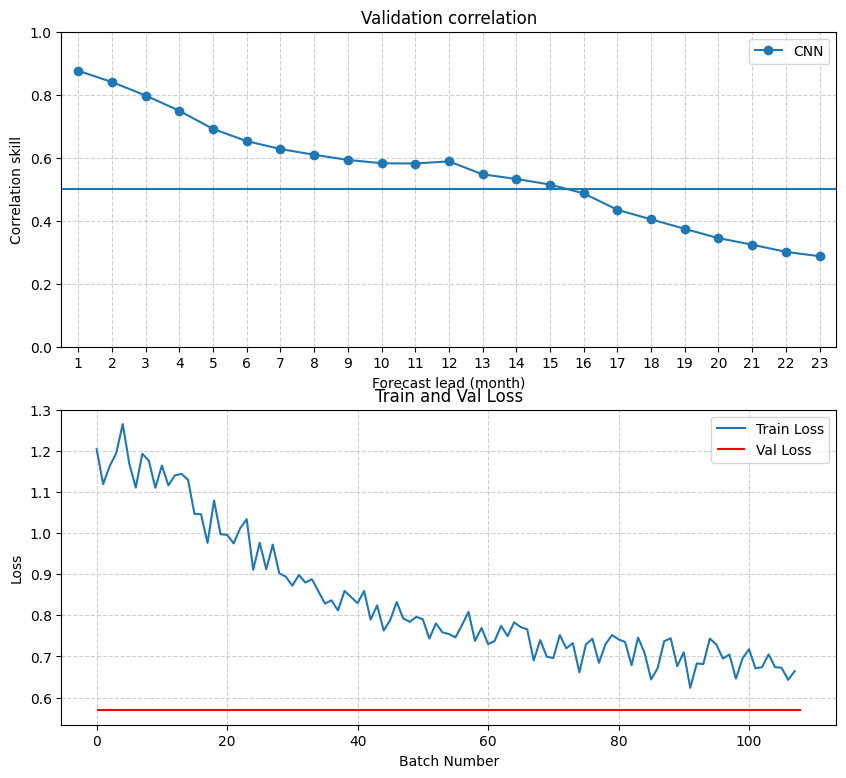

In [29]:
# 开始训练
args = Args()
exp_name = args.exp_name
exp_dir = f'experiments/{exp_name}'
if os.path.exists(exp_dir):
    raise ValueError('Experiment dir already existed, please rename this experiment!')

pretrain = args.pretrain
# Device
ms.set_context(mode=ms.PYNATIVE_MODE, device_target=args.device)
# Model
model = ConvNetwork(M_Num=args.M_Num, N_Num=args.N_Num)
# Data
if not pretrain:
    # Use both datasets together for training
    pretrain_dataset = ENSODataset("CMIP",T_begin=args.CMIP_start, T_end=args.CMIP_end)
    finetune_dataset = ENSODataset("OBSTrain", T_begin=args.OBSTrain_start, T_end=args.OBSTrain_end)
    train_loader = concat_mindspore_datasets(pretrain_dataset, finetune_dataset, batch_size=args.batch_size)
else:
    # use CMIP for pretrain and use OBSTrain for finetune later in "finetune.py"
    train_loader = create_mindspore_dataloader("CMIP", batch_size=args.batch_size, T_begin=args.CMIP_start, T_end=args.CMIP_end)
val_loader = create_mindspore_dataloader("OBSVal", batch_size=args.batch_size, T_begin=args.OBSVal_start, T_end=args.OBSVal_end)

# Optimizer
optimizer = nn.Adam(model.trainable_params(), learning_rate=args.lr)

# Start training
trainFunc(
    network=model,
    train_loader=train_loader,
    epochs=args.epochs,
    optimizer=optimizer,
    save_name=args.exp_name,
    val_loader=val_loader
)

# save fig and visualize
file_path = f"experiments/{exp_name}/logfile.pickle"
save_path = f"experiments/{exp_name}/result_fig.png"
trainPlot(filepath=file_path, save_path=save_path)